In [ ]:
# Change directory to VSCode workspace root so that relative path loads work correctly. Turn this addition off with the DataScience.changeDirOnImportExport setting
# ms-python.python added
import os
try:
	os.chdir(os.path.join(os.getcwd(), '../..'))
	print(os.getcwd())
except:
	pass


In [44]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report, cohen_kappa_score
from sklearn.model_selection import train_test_split
%load_ext autotime

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
------------------
Executed time in : 8.29 ms


In [2]:
# Read all Data
breeds = pd.read_csv('Mini Project 11/petfinder-adoption-prediction/breed_labels.csv')
colors = pd.read_csv('Mini Project 11/petfinder-adoption-prediction/color_labels.csv')
states = pd.read_csv('Mini Project 11/petfinder-adoption-prediction/state_labels.csv')

train = pd.read_csv('Mini Project 11/petfinder-adoption-prediction/train.csv')
test = pd.read_csv('Mini Project 11/petfinder-adoption-prediction/test/test.csv')
sub = pd.read_csv('Mini Project 11/petfinder-adoption-prediction/test/sample_submission.csv')

train_dfs_sentiment = pd.read_csv('Mini Project 11/Working Folder/DataExtraction/train_dsf_sentiment.csv')
train_dfs_metadata = pd.read_csv('Mini Project 11/Working Folder/DataExtraction/train_dfs_metadata.csv')
test_dfs_sentiment = pd.read_csv('Mini Project 11/Working Folder/DataExtraction/test_dfs_sentiment.csv')
test_dfs_metadata = pd.read_csv('Mini Project 11/Working Folder/DataExtraction/test_dfs_metadata.csv')

------------------
Executed time in : 2.03 s


In [3]:
aggregates = ['sum', 'mean', 'var', 'std']
sent_agg = ['sum']

# Train
train_metadata_desc = train_dfs_metadata.groupby(
    ['PetID'])['metadata_annots_top_desc'].unique()
train_metadata_desc = train_metadata_desc.reset_index()
train_metadata_desc[
    'metadata_annots_top_desc'] = train_metadata_desc[
    'metadata_annots_top_desc'].apply(lambda x: ' '.join(str(x)))

prefix = 'metadata'
train_metadata_gr = train_dfs_metadata.drop(
    ['metadata_annots_top_desc'], axis=1)
for i in train_metadata_gr.columns:
    if 'PetID' not in i:
        train_metadata_gr[i] = train_metadata_gr[i].astype(float)
train_metadata_gr = train_metadata_gr.groupby(['PetID']).agg(aggregates)
train_metadata_gr.columns = pd.Index(
    [f'{c[0]}_{c[1].upper()}' for c in train_metadata_gr.columns.tolist()])
train_metadata_gr = train_metadata_gr.reset_index()


train_sentiment_desc = train_dfs_sentiment.groupby(
    ['PetID'])['sentiment_entities'].unique()
train_sentiment_desc = train_sentiment_desc.reset_index()
train_sentiment_desc[
    'sentiment_entities'] = train_sentiment_desc[
    'sentiment_entities'].apply(lambda x: ' '.join(str(x)))

prefix = 'sentiment'
train_sentiment_gr = train_dfs_sentiment.drop(['sentiment_entities'], axis=1)
for i in train_sentiment_gr.columns:
    if 'PetID' not in i:
        train_sentiment_gr[i] = train_sentiment_gr[i].astype(float)
train_sentiment_gr = train_sentiment_gr.groupby(['PetID']).agg(sent_agg)
train_sentiment_gr.columns = pd.Index(
    [f'{c[0]}' for c in train_sentiment_gr.columns.tolist()])
train_sentiment_gr = train_sentiment_gr.reset_index()


------------------
Executed time in : 37.3 s


In [4]:
# Test
test_metadata_desc = test_dfs_metadata.groupby(['PetID'])['metadata_annots_top_desc'].unique()
test_metadata_desc = test_metadata_desc.reset_index()
test_metadata_desc['metadata_annots_top_desc'] = test_metadata_desc[
    'metadata_annots_top_desc'].apply(
        lambda x: ' '.join(str(x)))

prefix = 'metadata'
test_metadata_gr = test_dfs_metadata.drop(['metadata_annots_top_desc'], axis=1)
for i in test_metadata_gr.columns:
    if 'PetID' not in i:
        test_metadata_gr[i] = test_metadata_gr[i].astype(float)
test_metadata_gr = test_metadata_gr.groupby(['PetID']).agg(aggregates)
test_metadata_gr.columns = pd.Index([f'{c[0]}_{c[1].upper()}' for c in test_metadata_gr.columns.tolist()])
test_metadata_gr = test_metadata_gr.reset_index()


test_sentiment_desc = test_dfs_sentiment.groupby(['PetID'])['sentiment_entities'].unique()
test_sentiment_desc = test_sentiment_desc.reset_index()
test_sentiment_desc[
    'sentiment_entities'] = test_sentiment_desc[
    'sentiment_entities'].apply(lambda x: ' '.join(str(x)))

prefix = 'sentiment'
test_sentiment_gr = test_dfs_sentiment.drop(['sentiment_entities'], axis=1)
for i in test_sentiment_gr.columns:
    if 'PetID' not in i:
        test_sentiment_gr[i] = test_sentiment_gr[i].astype(float)
test_sentiment_gr = test_sentiment_gr.groupby(['PetID']).agg(sent_agg)
test_sentiment_gr.columns = pd.Index([f'{c[0]}' for c in test_sentiment_gr.columns.tolist()])
test_sentiment_gr = test_sentiment_gr.reset_index()


------------------
Executed time in : 9.94 s


In [5]:
# Train merges:
train_proc = train.copy()
train_proc = train_proc.merge(
    train_sentiment_gr, how='left', on='PetID')
train_proc = train_proc.merge(
    train_metadata_gr, how='left', on='PetID')
train_proc = train_proc.merge(
    train_metadata_desc, how='left', on='PetID')
train_proc = train_proc.merge(
    train_sentiment_desc, how='left', on='PetID')

# Test merges:
test_proc = test.copy()
test_proc = test_proc.merge(
    test_sentiment_gr, how='left', on='PetID')
test_proc = test_proc.merge(
    test_metadata_gr, how='left', on='PetID')
test_proc = test_proc.merge(
    test_metadata_desc, how='left', on='PetID')
test_proc = test_proc.merge(
    test_sentiment_desc, how='left', on='PetID')
print(train_proc.shape, test_proc.shape)

(14993, 56) (3972, 55)
------------------
Executed time in : 345 ms


In [16]:
xgb_params = {
    'eval_metric': 'rmse',
    'seed': 1337,
    'eta': 0.0123,
    'subsample': 0.8,
    'colsample_bytree': 0.85,
    'silent': 1,
}

------------------
Executed time in : 73.7 ms


In [7]:
def run_xgb(params, X_train, X_test):
    n_splits = 5
    verbose_eval = 1000
    num_rounds = 65000
    early_stop = 500

    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=1337)

    oof_train = np.zeros((X_train.shape[0]))
    oof_test = np.zeros((X_test.shape[0], n_splits))

    i = 0

    for train_idx, valid_idx in kf.split(X_train, X_train['AdoptionSpeed'].values):

        X_tr = X_train.iloc[train_idx, :]
        X_val = X_train.iloc[valid_idx, :]

        y_tr = X_tr['AdoptionSpeed'].values
        X_tr = X_tr.drop(['AdoptionSpeed'], axis=1)

        y_val = X_val['AdoptionSpeed'].values
        X_val = X_val.drop(['AdoptionSpeed'], axis=1)

        d_train = xgb.DMatrix(data=X_tr, label=y_tr, feature_names=X_tr.columns)
        d_valid = xgb.DMatrix(data=X_val, label=y_val, feature_names=X_val.columns)

        watchlist = [(d_train, 'train'), (d_valid, 'valid')]
        model = xgb.train(dtrain=d_train, num_boost_round=num_rounds, evals=watchlist,
                         early_stopping_rounds=early_stop, verbose_eval=verbose_eval, params=params)

        valid_pred = model.predict(xgb.DMatrix(X_val, feature_names=X_val.columns), ntree_limit=model.best_ntree_limit)
        test_pred = model.predict(xgb.DMatrix(X_test, feature_names=X_test.columns), ntree_limit=model.best_ntree_limit)

        oof_train[valid_idx] = valid_pred
        oof_test[:, i] = test_pred

        i += 1
    return model, oof_train, oof_test

------------------
Executed time in : 7.4 ms


In [8]:
# merger train_proc va test_proce
X = pd.concat([train_proc, test_proc], ignore_index=True, sort=False)


------------------
Executed time in : 53.7 ms


In [9]:
X_temp = X.copy()

# text_columns = ['Description', 'metadata_annots_top_desc', 'sentiment_entities']

# xoa cac cot chua su dung den trong lan nay
to_drop_columns = ['PetID', 'Name', 'RescuerID', 'Description',
                   'metadata_annots_top_desc', 'sentiment_entities', ]
X_temp = X_temp.drop(to_drop_columns, axis=1)

------------------
Executed time in : 36.8 ms


In [10]:
X_train = X_temp.loc[np.isfinite(X_temp.AdoptionSpeed),:]
X_test = X_temp.loc[~np.isfinite(X_temp.AdoptionSpeed), :]


------------------
Executed time in : 12.1 ms


In [11]:
X_test = X_test.drop(['AdoptionSpeed'], axis=1)
# Check error 2 tap train va tap tao ra
assert X_train.shape[0] == train.shape[0]
assert X_test.shape[0] == test.shape[0]

train_cols = X_train.columns.tolist()
train_cols.remove('AdoptionSpeed')

test_cols = X_test.columns.tolist()

assert np.all(train_cols == test_cols)


------------------
Executed time in : 10.4 ms


In [12]:
# Xu ly NaN value
X_train_non_null = X_train.fillna(-1)
X_test_non_null = X_test.fillna(-1)


------------------
Executed time in : 10.5 ms


In [13]:
# X_train_non_null.to_csv('Mini Project 11/Working Folder/DataExtraction/X_train_non_null.csv',index=False)
# X_test_non_null.to_csv('Mini Project 11/Working Folder/DataExtraction/X_test_non_null.csv', index=False)

------------------
Executed time in : 478 µs


In [14]:
X_train_non_null.isnull().any().any(), X_test_non_null.isnull().any().any()


(False, False)

------------------
Executed time in : 26.4 ms


In [17]:
# Train model
model, oof_train, oof_test = run_xgb(
    xgb_params, X_train_non_null, X_test_non_null)


[0]	train-rmse:2.31253	valid-rmse:2.31234
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 500 rounds.
[1000]	train-rmse:0.813095	valid-rmse:1.06561
Stopping. Best iteration:
[674]	train-rmse:0.874126	valid-rmse:1.06452

[0]	train-rmse:2.31234	valid-rmse:2.3126
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 500 rounds.
[1000]	train-rmse:0.812177	valid-rmse:1.06004
Stopping. Best iteration:
[863]	train-rmse:0.836504	valid-rmse:1.05973

[0]	train-rmse:2.31229	valid-rmse:2.31327
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 500 rounds.
[1000]	train-rmse:0.812311	valid-rmse:1.07252
Stopping. Best iteration:
[682]	train-rmse:0.873189	valid-rmse:1.07133

[0]	train-rmse:2.31247	valid-rmse:2.3127
Multiple eval metrics have been passed: 'v

In [42]:
class OptimizedRounder(object):
    def __init__(self):
        self.coef_ = 0
    
    def _kappa_loss(self, coef, X, y):
        preds = pd.cut(X, [-np.inf] + list(np.sort(coef)) + [np.inf], labels = [0, 1, 2, 3, 4])
        return -cohen_kappa_score(y, preds, weights='quadratic')
    
    def fit(self, X, y):
        from functools import partial
        import scipy as sp
        loss_partial = partial(self._kappa_loss, X = X, y = y)
        initial_coef = [0.5, 1.5, 2.5, 3.5]
        self.coef_ = sp.optimize.minimize(loss_partial, initial_coef, method='nelder-mead')
    
    def predict(self, X, coef):
        preds = pd.cut(X, [-np.inf] + list(np.sort(coef)) + [np.inf], labels = [0, 1, 2, 3, 4])
        return preds
    
    def coefficients(self):
        return self.coef_['x']

------------------
Executed time in : 4.52 ms


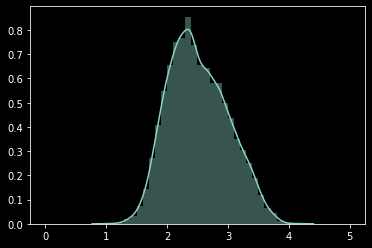

------------------
Executed time in : 2.94 s


In [26]:
sns.distplot(oof_train, kde=True, hist_kws={'range': [0, 5]})

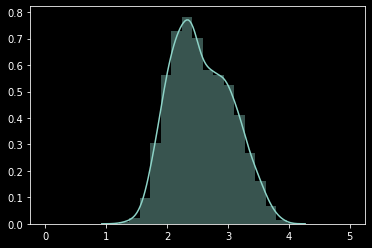

------------------
Executed time in : 1.88 s


In [35]:
sns.distplot(oof_test.mean(axis=1), kde=True, hist_kws={'range': [0, 5]})

In [53]:
optR = OptimizedRounder()
optR.fit(oof_train, X_train['AdoptionSpeed'].values)
coefficients = optR.coefficients()
valid_pred = optR.predict(oof_train, coefficients)

------------------
Executed time in : 9.18 s


In [58]:
coefficients_ = coefficients.copy()
coefficients_[0] = 1.66
coefficients_[1] = 2.13
coefficients_[3] = 2.85
from collections import Counter
train_predictions = optR.predict(oof_train, coefficients_)
print(f'train pred distribution: {Counter(train_predictions)}')
test_predictions = optR.predict(oof_test.mean(axis=1), coefficients_)
print(f'test pred distribution: {Counter(test_predictions)}')

train pred distribution: Counter({2: 5089, 4: 3831, 1: 3239, 3: 2521, 0: 313})
test pred distribution: Counter({2: 1329, 4: 1177, 1: 792, 3: 623, 0: 51})
------------------
Executed time in : 22.1 ms


In [60]:
submission = pd.DataFrame({'PetID': test['PetID'].values, 'AdoptionSpeed': test_predictions})
print(submission.head())
submission.to_csv('Mini Project 11/Working Folder/DataExtraction/submission.csv', index=False)

PetID AdoptionSpeed
0  e2dfc2935             3
1  f153b465f             2
2  3c90f3f54             1
3  e02abc8a3             4
4  09f0df7d1             3
------------------
Executed time in : 85.3 ms
